<a href="https://colab.research.google.com/github/Boltfox/Radio_astronomy_tutorial/blob/main/AIAT_tutorial_radio_telescope_developing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import matplotlib.image as mpimg
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage
from scipy.spatial.distance import pdist

In [ ]:
def FWHM(x, y):
    deltax = x[1] - x[0]
    half_max = max(y) / 2.
    l = np.where(y > half_max, 1, 0)

    return np.sum(l) * deltax



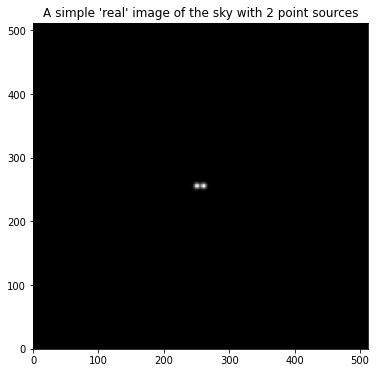

In [ ]:
def gaussian_2d(size, sigma, center):
    x, y = np.mgrid[-size:size, -size:size]
    x = x - center[0]
    y = y - center[1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return g/g.sum()

#deg=(np.arange(512)-256)*180/np.pi

fig, axes = plt.subplots(figsize=(6,6), nrows=1, ncols=1, facecolor='white')
sigma = 3
center = (0,-5)
center2 = (0,5)
img=gaussian_2d(256, sigma, center)+gaussian_2d(256, sigma, center2)
plt.pcolor(img,cmap='gray')
plt.title("A simple 'real' image of the sky with 2 point sources")
#plt.xlim(0-2000,0+2000)
#plt.ylim(0-2000,0+2000)
fftImg0=np.fft.fftshift(np.fft.fft2(img))

In [ ]:
def circularSamplingMap(imgSize, outer, centerX, centerY,inner=0):
    """Return a circular sampling map of size [imgSize, imgSize]
    imgSize: image size in pixels
    outer: outer radius (in pixels) to exclude sampling above
    inner: inner radius (in pixels) to exclude sampling below
    centerX: X coordinate of the center of the circular sampling map
    centerY: Y coordinate of the center of the circular sampling map"""
    zeros = np.zeros((imgSize,imgSize), dtype='float')
    ones = np.ones((imgSize,imgSize), dtype='float')
    xpos, ypos = np.mgrid[0:imgSize,0:imgSize]
    radius = np.sqrt((xpos - centerX)**2. + (ypos - centerY)**2.)
    sampling = np.where((outer >= radius) & (radius >= inner), ones, zeros)
    return sampling

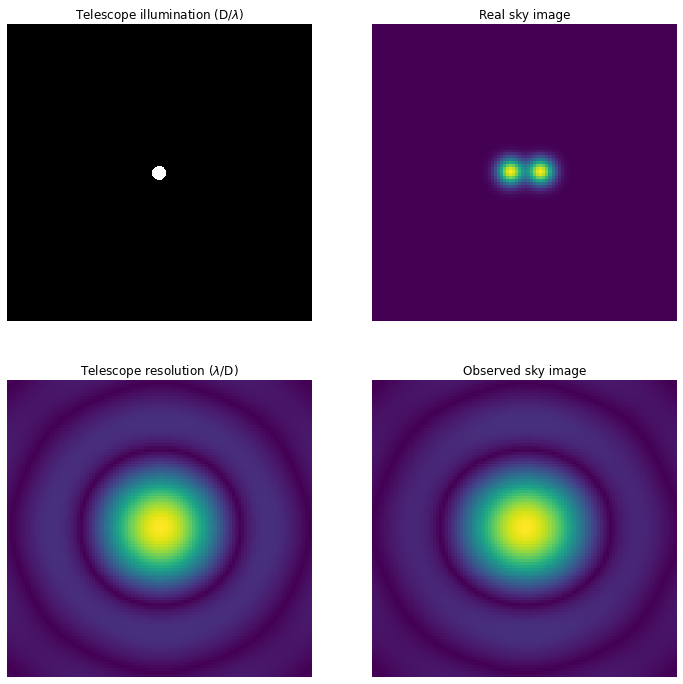

In [ ]:
imsize=512
D=2.4
lambda_=0.2
Dl=D/lambda_
sampling = circularSamplingMap(imsize,Dl, imsize/2,imsize/2,0)
fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, facecolor='white')

axes[0,0].pcolor(sampling,cmap='gray')
axes[0,0].set_title('Telescope illumination (D/$\lambda$)')
axes[0,0].axis('off')

axes[0,1].pcolor(img)
axes[0,1].set_title('Real sky image')
axes[0,1].axis('off')
psf = np.abs( np.fft.fftshift( np.fft.fft2(sampling)))
axes[1,0].pcolor(psf)
axes[1,0].set_title('Telescope resolution ($\lambda$/D)')
axes[1,0].axis('off')
obsSky = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg0)))
axes[1,1].pcolor(obsSky)
axes[1,1].set_title('Observed sky image')
axes[1,1].axis('off')

for ax in axes.flat:
  if ax is not axes[0,0]:
    ax.set_xlim(imsize/2-50,imsize/2+50)
    ax.set_ylim(imsize/2-50,imsize/2+50)
  ax.axis('off')
plt.show()

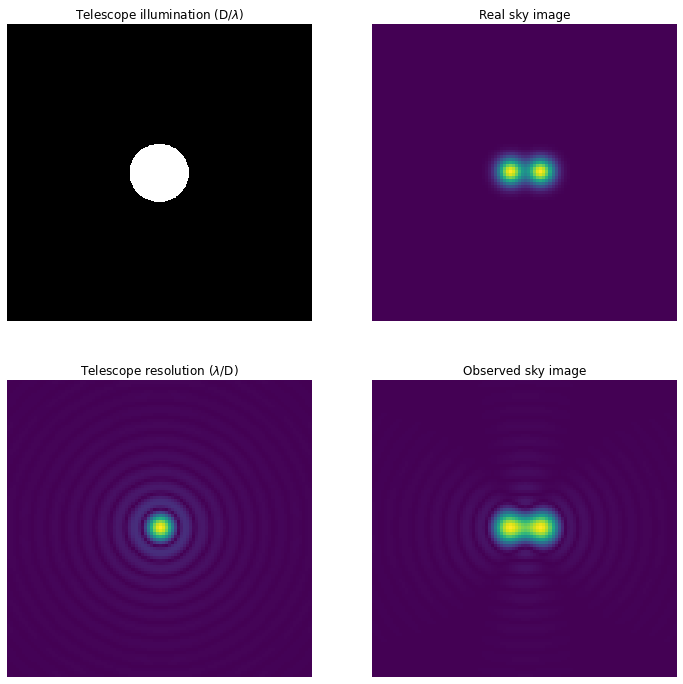

In [ ]:
imsize=512
D=10
lambda_=0.2
Dl=D/lambda_
sampling = circularSamplingMap(imsize,Dl, imsize/2,imsize/2,0)
fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, facecolor='white')

axes[0,0].pcolor(sampling,cmap='gray')
axes[0,0].set_title('Telescope illumination (D/$\lambda$)')

axes[0,1].pcolor(img)
axes[0,1].set_title('Real sky image')
psf = np.abs( np.fft.fftshift( np.fft.fft2(sampling)))
axes[1,0].pcolor(psf)
axes[1,0].set_title('Telescope resolution ($\lambda$/D)')

obsSky = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg0)))
axes[1,1].pcolor(obsSky)
axes[1,1].set_title('Observed sky image')
for ax in axes.flat:
  if ax is not axes[0,0]:
    ax.set_xlim(imsize/2-50,imsize/2+50)
    ax.set_ylim(imsize/2-50,imsize/2+50)
  ax.axis('off')
plt.show()

In [ ]:
def caluv(coords):
  # physical coordinates of radio telescopes
  telescope_coords = coords
  n = telescope_coords.shape[0]

  # wavelength
  lambda_ = 0.2

  # convert telescope coordinates to sky coordinates
  sky_coords = np.zeros((n,2))
  for i in range(n):
      sky_coords[i,0] = lambda_ * telescope_coords[i,0]
      sky_coords[i,1] = lambda_ * telescope_coords[i,1]

  u=[]
  v=[]
  for i,j in sky_coords:
    for m,n in sky_coords:
      if i!=m or j!=n:
        u.append(i-m)
        v.append(j-n)
  print(u,v)

  # Calculate u and v coordinates
  plt.scatter(u,v)
  return (u,v)

In [ ]:
def earth_rotate(coor,T):
  deg=1/(240.0) #The Earth rotates 1 deg per 4 mins
  new_coor = []
  for i in range(len(coor)):
    r = np.sqrt(coor[i][0]**2 + coor[i][1]**2)
    #print(r,np.sin(deg*T*np.pi/180.0))
    new_coor.append((r*np.sin(deg*T*np.pi/180.0), r*np.cos(deg*T*np.pi/180.0)))
  #print(new_coor)
  return new_coor

In [ ]:
coor =np.asarray([[0,0],[0,10],[0,20],[0,30]]) # Telescope coordinates
nc=[]
#nc.append(coor)
for i in range(0,15):
    nc.append(earth_rotate(coor,i*240))
npc=np.asarray(nc)

In [ ]:
nc = []
for i in range(0,30):
    rotated_coor = earth_rotate(coor, i*240)
    for j in range(2):
        nc.append(rotated_coor[j])
npc = np.asarray(nc)

In [ ]:
npc

array([[ 0.        ,  0.        ],
       [ 0.        , 10.        ],
       [ 0.        ,  0.        ],
       [ 0.17452406,  9.99847695],
       [ 0.        ,  0.        ],
       [ 0.34899497,  9.99390827],
       [ 0.        ,  0.        ],
       [ 0.52335956,  9.98629535],
       [ 0.        ,  0.        ],
       [ 0.69756474,  9.9756405 ],
       [ 0.        ,  0.        ],
       [ 0.87155743,  9.96194698],
       [ 0.        ,  0.        ],
       [ 1.04528463,  9.94521895],
       [ 0.        ,  0.        ],
       [ 1.21869343,  9.92546152],
       [ 0.        ,  0.        ],
       [ 1.39173101,  9.90268069],
       [ 0.        ,  0.        ],
       [ 1.56434465,  9.87688341],
       [ 0.        ,  0.        ],
       [ 1.73648178,  9.84807753],
       [ 0.        ,  0.        ],
       [ 1.90808995,  9.81627183],
       [ 0.        ,  0.        ],
       [ 2.07911691,  9.78147601],
       [ 0.        ,  0.        ],
       [ 2.24951054,  9.74370065],
       [ 0.        ,

[0.0, -0.03490481287456703, -0.06979899340500194, -0.10467191248588766, -0.1395129474882506, -0.17431148549531633, -0.20905692653530694, -0.24373868681029498, -0.2783462019201309, -0.31286893008046174, -0.34729635533386066, -0.38161799075308966, -0.41582338163551863, -0.44990210868773, -0.48384379119933546, -0.5176380902050415, -0.5512747116339983, -0.5847434094454735, -0.6180339887498949, -0.6511363089143134, -0.6840402866513374, -0.7167358990906005, -0.749213186831824, -0.7814622569785474, -0.8134732861516003, -0.845236523481399, -0.8767422935781548, -0.9079809994790935, -0.9389431255717817, -0.9696192404926741, 0.0, 0.0, -0.03490481287456703, 0.0, -0.06979899340500194, 0.0, -0.10467191248588766, 0.0, -0.1395129474882506, 0.0, -0.17431148549531633, 0.0, -0.20905692653530694, 0.0, -0.24373868681029498, 0.0, -0.2783462019201309, 0.0, -0.31286893008046174, 0.0, -0.34729635533386066, 0.0, -0.38161799075308966, 0.0, -0.41582338163551863, 0.0, -0.44990210868773, 0.0, -0.48384379119933546, 

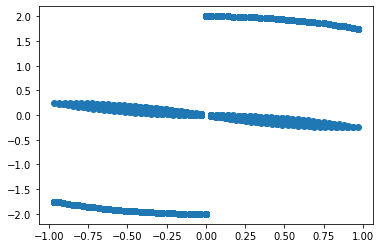

In [ ]:
u,v=caluv(npc)

[0.0,
 -0.03490481287456703,
 -0.06979899340500194,
 -0.10467191248588766,
 -0.1395129474882506,
 -0.17431148549531633,
 -0.20905692653530694,
 -0.24373868681029498,
 -0.2783462019201309,
 -0.31286893008046174,
 -0.34729635533386066,
 -0.38161799075308966,
 -0.41582338163551863,
 -0.44990210868773,
 -0.48384379119933546,
 -0.5176380902050415,
 -0.5512747116339983,
 -0.5847434094454735,
 -0.6180339887498949,
 -0.6511363089143134,
 -0.6840402866513374,
 -0.7167358990906005,
 -0.749213186831824,
 -0.7814622569785474,
 -0.8134732861516003,
 -0.845236523481399,
 -0.8767422935781548,
 -0.9079809994790935,
 -0.9389431255717817,
 -0.9696192404926741,
 -0.9999999999999999,
 -1.0300761498201083,
 -1.0598385284664098,
 -1.0892780700300542,
 -1.1183858069414938,
 -1.147152872702092,
 -1.1755705045849465,
 -1.2036300463040968,
 -1.2313229506513164,
 -1.2586407820996748,
 -1.2855752193730785,
 -1.3121180579810146,
 -1.3382612127177165,
 -1.3639967201249972,
 -1.3893167409179945,
 -1.414213562373095,

[0.0, -0.03490481287456703, -0.06979899340500194, -0.10467191248588766, -0.1395129474882506, -0.17431148549531633, -0.20905692653530694, -0.24373868681029498, -0.2783462019201309, -0.31286893008046174, -0.34729635533386066, -0.38161799075308966, -0.41582338163551863, -0.44990210868773, -0.48384379119933546, -0.5176380902050415, -0.5512747116339983, -0.5847434094454735, -0.6180339887498949, -0.6511363089143134, -0.6840402866513374, -0.7167358990906005, -0.749213186831824, -0.7814622569785474, -0.8134732861516003, -0.845236523481399, -0.8767422935781548, -0.9079809994790935, -0.9389431255717817, -0.9696192404926741, 0.0, 0.0, -0.03490481287456703, 0.0, -0.06979899340500194, 0.0, -0.10467191248588766, 0.0, -0.1395129474882506, 0.0, -0.17431148549531633, 0.0, -0.20905692653530694, 0.0, -0.24373868681029498, 0.0, -0.2783462019201309, 0.0, -0.31286893008046174, 0.0, -0.34729635533386066, 0.0, -0.38161799075308966, 0.0, -0.41582338163551863, 0.0, -0.44990210868773, 0.0, -0.48384379119933546, 

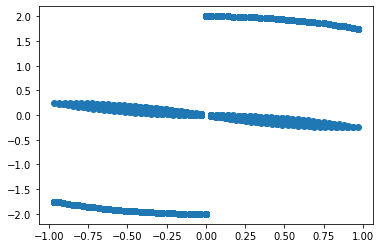

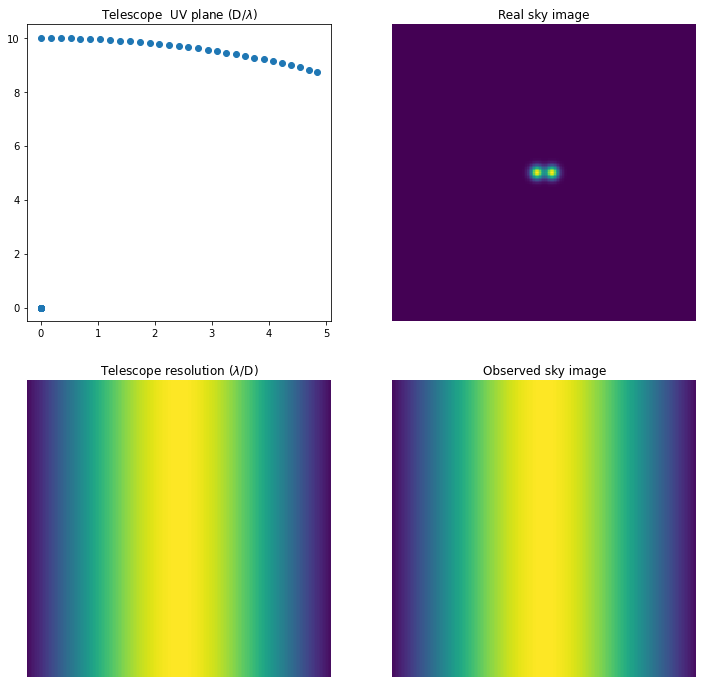

In [ ]:
imsize=512
D=100
W=100
lambda_=0.2
Dl=D/lambda_
coor = np.asarray([[0,0],[0,10],[0,20],[0,30]]) # Telescope coordinates
nc = []
for i in range(0,30):
    rotated_coor = earth_rotate(coor, i*240)
    for j in range(2):
        nc.append(rotated_coor[j])
npc = np.asarray(nc)
u,v=caluv(npc)
sampling = np.zeros((imsize,imsize), dtype='float')
for i in range(0,len(v)):
  sampling[imsize//2+int(u[i]),imsize//2+int(v[i])]=1

fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, facecolor='white')

axes[0,0].scatter(npc.transpose()[0],npc.transpose()[1])
axes[0,0].set_title('Telescope  UV plane (D/$\lambda$)')

axes[0,1].pcolor(img)
axes[0,1].set_title('Real sky image')
psf = np.abs( np.fft.fftshift( np.fft.fft2(sampling)))
axes[1,0].pcolor(psf)
axes[1,0].set_title('Telescope resolution ($\lambda$/D)')

obsSky = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg0)))
axes[1,1].pcolor(obsSky)
axes[1,1].set_title('Observed sky image')
for ax in axes.flat:
  if ax is not axes[0,0]:
    ax.set_xlim(imsize/2-100,imsize/2+100)
    ax.set_ylim(imsize/2-100,imsize/2+100)
    ax.axis('off')
plt.show()

[0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, -10, -20, -30, -40, -50, -60, -70, -80, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 10, -10, -20, -30, -40, -50, -60, -70, 30, 30, 30, 3

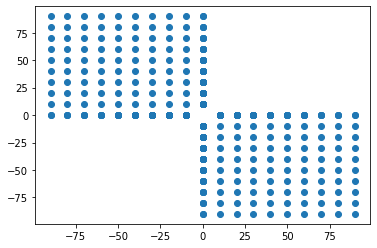

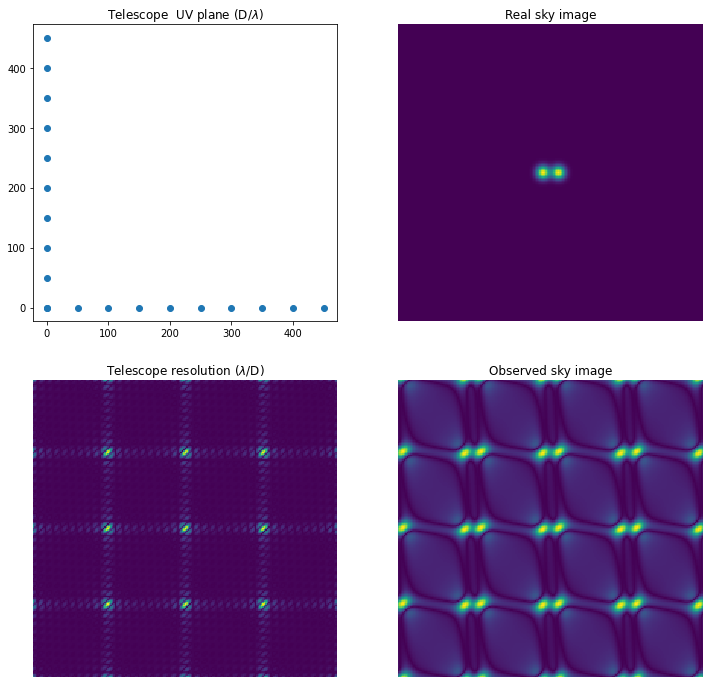

In [ ]:
imsize=512
D=100
W=100
lambda_=0.2
Dl=D/lambda_
array1 = np.asarray([[0,i] for i in range(0,500,50)])
array2 = np.asarray([[i,0] for i in range(0,500,50)])
#array3 = np.asarray([[20,i] for i in range(0,500,50)])
#array4 = np.asarray([[30,i] for i in range(0,500,50)])
coor = np.concatenate((array1, array2))
u,v=caluv(coor)
sampling = np.zeros((imsize,imsize), dtype='float')
for i in range(0,len(v)):
  sampling[imsize//2+u[i],imsize//2+v[i]]=1

fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, facecolor='white')

axes[0,0].scatter(coor.transpose()[0],coor.transpose()[1])
axes[0,0].set_title('Telescope  UV plane (D/$\lambda$)')

axes[0,1].pcolor(img)
axes[0,1].set_title('Real sky image')
psf = np.abs( np.fft.fftshift( np.fft.fft2(sampling)))
axes[1,0].pcolor(psf)
axes[1,0].set_title('Telescope resolution ($\lambda$/D)')

obsSky = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg0)))
axes[1,1].pcolor(obsSky)
axes[1,1].set_title('Observed sky image')
for ax in axes.flat:
  if ax is not axes[0,0]:
    ax.set_xlim(imsize/2-100,imsize/2+100)
    ax.set_ylim(imsize/2-100,imsize/2+100)
    ax.axis('off')
plt.show()

In [ ]:
imsize=512
D=100
W=100
lambda_=0.2
Dl=D/lambda_
array1 = np.asarray([[0,i] for i in range(0,500,50)])
array2 = np.asarray([[i,0] for i in range(0,500,50)])
coor = np.concatenate((array1, array2))
u,v=caluv(coor)
sampling = np.zeros((imsize,imsize), dtype='float')
for i in range(0,len(v)):
  sampling[imsize//2+u[i],imsize//2+v[i]]=1

fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, facecolor='white')

axes[0,0].scatter(coor.transpose()[0],coor.transpose()[1])
axes[0,0].set_title('Telescope  UV plane (D/$\lambda$)')

axes[0,1].pcolor(img)
axes[0,1].set_title('Real sky image')
psf = np.abs( np.fft.fftshift( np.fft.fft2(sampling)))
axes[1,0].pcolor(psf)
axes[1,0].set_title('Telescope resolution ($\lambda$/D)')

obsSky = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg0)))
axes[1,1].pcolor(obsSky)
axes[1,1].set_title('Observed sky image')
for ax in axes.flat:
  if ax is not axes[0,0]:
    ax.set_xlim(imsize/2-100,imsize/2+100)
    ax.set_ylim(imsize/2-100,imsize/2+100)
    ax.axis('off')
plt.show()

[0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, -9, -9, -9, -9, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, -9, -9, -9, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, -9, -9, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, -9, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2

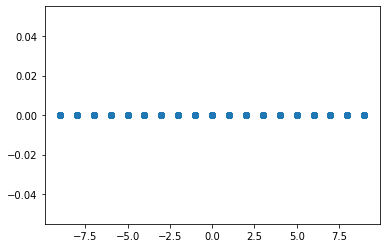

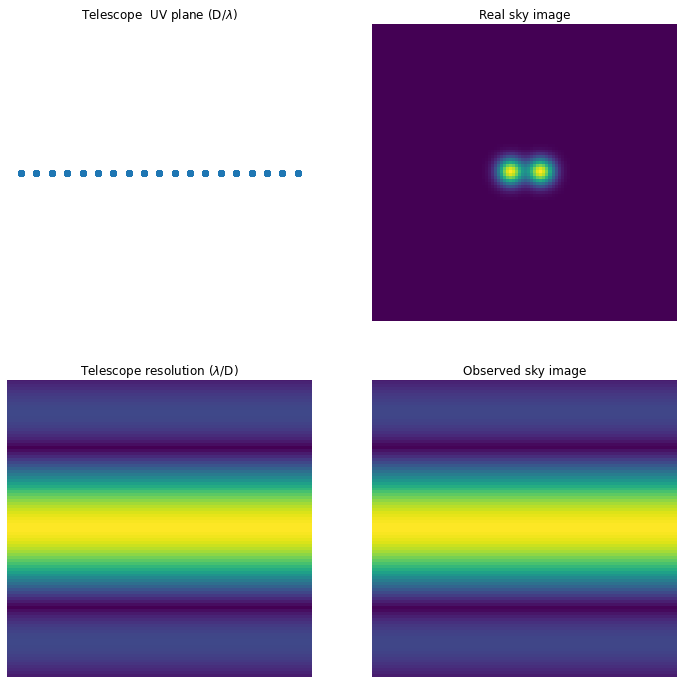

In [ ]:
imsize=512
D=100
lambda_=0.2
Dl=D/lambda_
coor = np.asarray([[i,0] for i in range(0,50,1)])
u,v=caluv(coor)
sampling = np.zeros((imsize,imsize), dtype='float')
for i in range(0,len(v)):
  sampling[imsize//2+u[i],imsize//2+v[i]]=1

fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, facecolor='white')

axes[0,0].scatter(u,v)
axes[0,0].set_title('Telescope  UV plane (D/$\lambda$)')

axes[0,1].pcolor(img)
axes[0,1].set_title('Real sky image')
psf = np.abs( np.fft.fftshift( np.fft.fft2(sampling)))
axes[1,0].pcolor(psf)
axes[1,0].set_title('Telescope resolution ($\lambda$/D)')

obsSky = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg0)))
axes[1,1].pcolor(obsSky)
axes[1,1].set_title('Observed sky image')
for ax in axes.flat:
  if ax is not axes[0,0]:
    ax.set_xlim(imsize/2-50,imsize/2+50)
    ax.set_ylim(imsize/2-50,imsize/2+50)
  ax.axis('off')
plt.show()

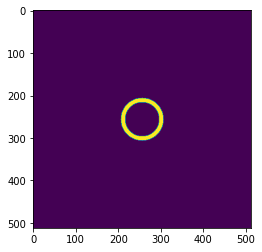

In [ ]:
image = circularSamplingMap(imsize,50, imsize/2,imsize/2,40)
fftImg=np.fft.fftshift(np.fft.fft2(image))

plt.imshow(image)

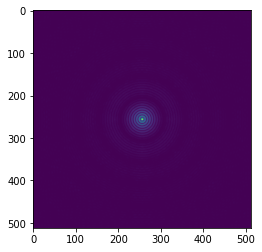

In [ ]:
plt.imshow(np.abs(fftImg))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

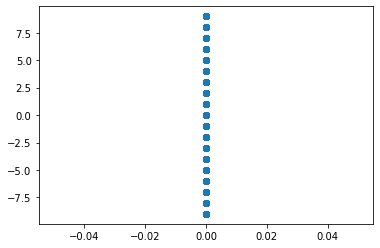

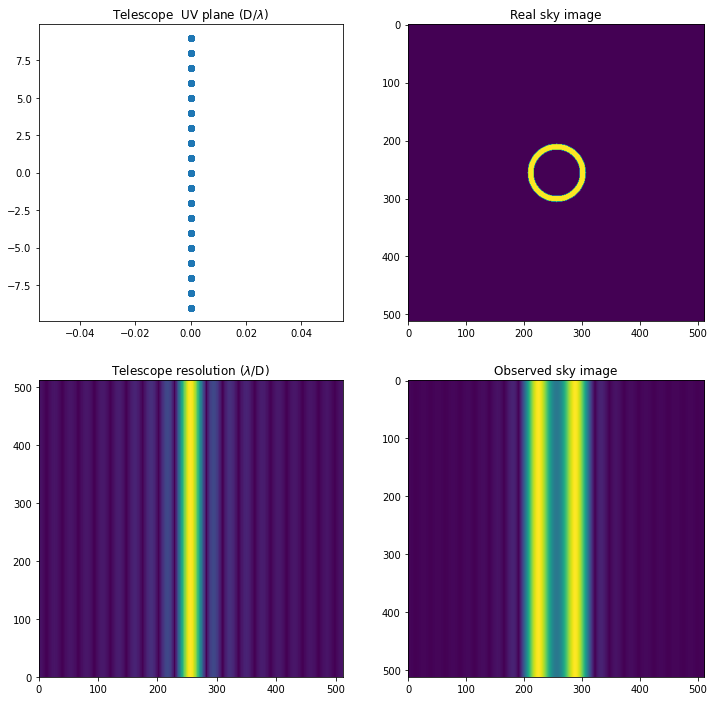

In [ ]:
imsize=512
D=1
lambda_=0.2
Dl=D/lambda_
coor = np.asarray([[0,i] for i in range(0,50,1)])
u,v=caluv(coor)
sampling = np.zeros((imsize,imsize), dtype='float')
for i in range(0,len(v)):
  sampling[imsize//2+u[i],imsize//2+v[i]]=1
fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, facecolor='white')

axes[0,0].scatter(u,v)
axes[0,0].set_title('Telescope  UV plane (D/$\lambda$)')

axes[0,1].imshow(image)
axes[0,1].set_title('Real sky image')
psf = np.abs( np.fft.fftshift( np.fft.fft2(sampling)))
axes[1,0].pcolor(psf)
axes[1,0].set_title('Telescope resolution ($\lambda$/D)')

obsSky = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg)))
axes[1,1].imshow(obsSky)
axes[1,1].set_title('Observed sky image')

plt.show()

[0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, -9, -9, -9, -9, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, -9, -9, -9, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, -9, -9, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, -9, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -4, -4, -4, -4, -4, -5, -5, -5, -5, -5, -6, -6, -6, -6, -6, -7, -7, -7, -7, -7, -8, -8, -8, -8, -8, -9, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -2

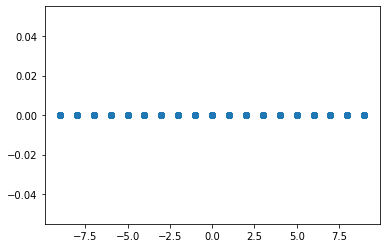

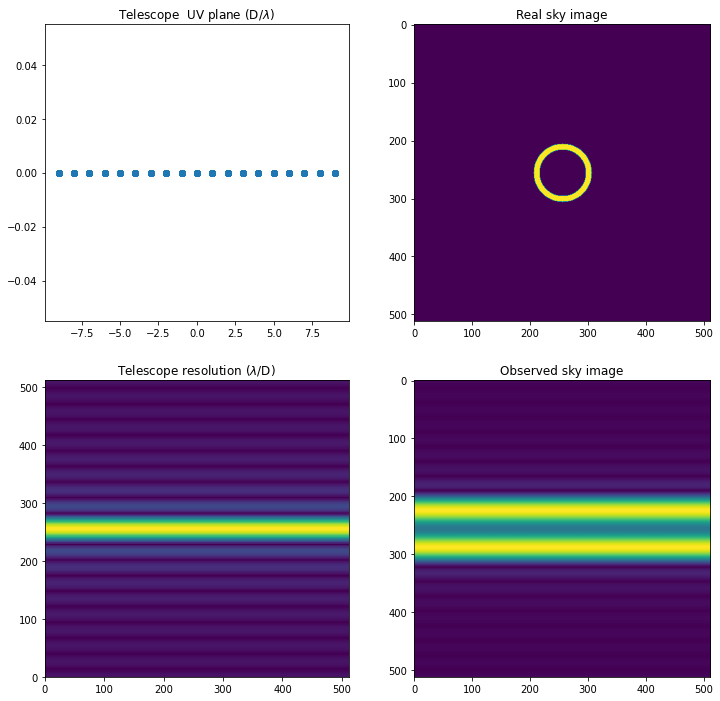

In [ ]:
imsize=512
D=1
lambda_=0.2
Dl=D/lambda_
coor = np.asarray([[i,0] for i in range(0,50,1)])
u,v=caluv(coor)
sampling = np.zeros((imsize,imsize), dtype='float')
for i in range(0,len(v)):
  sampling[imsize//2+u[i],imsize//2+v[i]]=1
fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, facecolor='white')

axes[0,0].scatter(u,v)
axes[0,0].set_title('Telescope  UV plane (D/$\lambda$)')

axes[0,1].imshow(image)
axes[0,1].set_title('Real sky image')
psf = np.abs( np.fft.fftshift( np.fft.fft2(sampling)))
axes[1,0].pcolor(psf)
axes[1,0].set_title('Telescope resolution ($\lambda$/D)')

obsSky = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg)))
axes[1,1].imshow(obsSky)
axes[1,1].set_title('Observed sky image')

plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IndexError: ignored

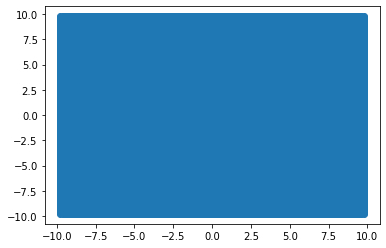

In [ ]:
imsize=512
D=1
lambda_=0.2
Dl=D/lambda_
coor = np.asarray([[i,j] for i in range(0,50,1) for j in range(0,50,1)])
u,v=caluv(coor)
sampling = np.zeros((imsize,imsize), dtype='float')
for i in range(0,len(v)):
  sampling[imsize//2+u[i],imsize//2+v[i]]=1
fig, axes = plt.subplots(figsize=(12,12), nrows=2, ncols=2, facecolor='white')

axes[0,0].scatter(u,v)
axes[0,0].set_title('Telescope  UV plane (D/$\lambda$)')

axes[0,1].imshow(image)
axes[0,1].set_title('Real sky image')
psf = np.abs( np.fft.fftshift( np.fft.fft2(sampling)))
axes[1,0].pcolor(psf)
axes[1,0].set_title('Telescope resolution ($\lambda$/D)')

obsSky = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg)))
axes[1,1].imshow(obsSky)
axes[1,1].set_title('Observed sky image')

plt.show()